[1078.62024552 1092.82991686 1106.63167211 1101.30681055 1094.951956
 1092.28643971 1090.40601787 1087.33991444 1081.56123546 1077.27072665
 1074.64717931 1094.57434539 1113.10541333 1117.47149247 1132.13230863
 1136.21102145 1134.70715256 1132.14108646 1133.87594529 1152.6120066
 1152.63630362 1161.35882193 1158.1789632  1165.79087738 1186.6900742
 1198.71646088 1193.72672618 1204.90525056 1210.20615873 1209.2182587
 1199.91160227 1204.89812605 1203.86937592 1139.65590353 1089.15206008] 0.9779560185171885 35


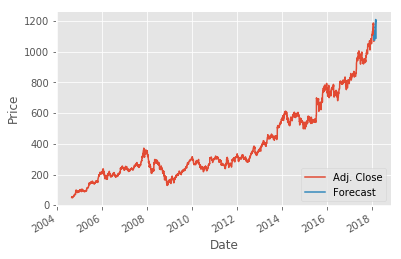

In [7]:
import quandl as ql 
import sklearn
import pandas as pd
import math, datetime
import numpy as np # no problem! :D
import pickle 
from sklearn import preprocessing, model_selection, svm # Getting features to be nice and pretty, normalsing data, shuffle and split data so our samples aren't biased from order effects, svm is useful with regressions
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt #graphing
from matplotlib import style # make it look nice
style.use ('ggplot')
# Using continous data to come up with a best fit line to explain the relationship between the dependent variable and indepedent variables(s)
# Stock prices example

# the following are features not labels! 

df= ql.get("WIKI/GOOGL") # creates a dataframe consisting of Google stock prices, which will be the data used for our regression Is Google a good stock to buy or not?! Let's see!
#print (df.head()) # Print out a little summary of the dataset we'll be using. Also helpful to see which "features" the data presents
df [["Adj. Open","Adj. High","Adj. Low","Adj. Close"]] # Creates a new df of selected values from the previous df
df ["HL_Pct"] = (df["Adj. High"]- df["Adj. Low"] / df["Adj. Low"] *100.0) # calculate the percentage change from adjusted high variable from adjusted low
df ["OC_Pct"] = (df["Adj. Close"]- df["Adj. Open"] / df["Adj. Open"] *100.0) # now calculating the percentage change from closing value from opening value

df = df[["Adj. Close","HL_Pct", "OC_Pct", "Adj. Volume"]] # Defining the columns that will be actually needed for the regression
#print (df.head()) # Helps keeps me honest by seeing exactly what i'm defining in previous lines.

forecast_col = "Adj. Close"
df.fillna(-99999, inplace= True) # Replacing NAN data, Especially important in machine learning

forecast_out = int(math.ceil (0.01*len(df))) #Forecasting out 1% of the data. math.ceil will round everything up to nearest whole number (integer not float)

df["label"] = df[forecast_col].shift(-forecast_out)# Shifting future rows of adj close price up the spreadsheet and 10% into the future

#print (df.head()) #again checking to see if i did't muck up the code and everything prints out as expected, should see an increase in stock price from adj close to the 1% in the future label


X = np.array(df.drop (["label"],1)) # X will be our features variable, and dropping the word 'label' from our new numpy array
Y = np.array(df["label"]) # new label dataframe

X = preprocessing.scale(X) # Scaling X before we feed it into the classifer. Normalising it alongside all of the other values.
X = X[:-forecast_out]
X_lately = X[-forecast_out:] # What we're going to use to predict against 

df.dropna(inplace=True)
Y = np.array(df["label"])
X = X[0:] # Sliced my X array to balance out X's and Y's

#print (len(X),len (Y)) # Making sure the length of X and Y are equal

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2) #20% of the data to be used as testing data, shuffling combined (X,Y) pair

##clf = LinearRegression() # Using a Linear Regression algorithm
#clf = svm.SVR() # Using a Support Vector Regression as a comparison algorithm
##clf.fit(X_train, Y_train) # Fitting the training data
##with open  ('linearregression.pickle','wb')as f: # pickeling the linear regression, running it then commenting it out to run the new file created to test if the graph still plots
## pickle.dump(clf,f)
    
pickle_in = open ('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, Y_test) # compute the accuracy of this linear regression, or what the price will be 1% into the future, squared error for LR
#print(accuracy) #seeing what the accuarcy of our model is 
#print (forecast_out) # wanted to see how many days it is forecasting out. a little over a month

forecast_set= clf.predict(X_lately)
print(forecast_set, accuracy, forecast_out) #The values of the next 35 days worth of stock prices with accuracy included
# Plotting as a function of time
df ['Forecast']= np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400 #seconds in a day 
next_unix = last_unix + one_day

#Populating the new dates with the forcast value, iterating through the forecast set taking each forecast and day and setting that as the values in the dataframe
# making the future features not a number 
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i] # Filling in the columns in the dataframe that are forcasted values with 'Nan'
df ['Adj. Close'].plot()
df ['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show() # Visualise the estimated stock growth
#print (df.tail()) # End of dataframe to see where the Nan will be placed

